In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

torch.manual_seed(42)

In [4]:
import cudf as cd
import numpy as np

df = cd.read_csv("smh_stocks_max.csv")
df = df.fillna(0)
df["volume"] = df["volume"].astype(float)
scaler = MinMaxScaler((0,1))
df.drop("Date", inplace=True, axis=1)
df.head()

,open,high,low,close,volume,dividends,stock splits,capital gains,sma_200,ema_200,...,bb_lower,roc,hi_lo,hi_close,lo_close,true_range,ATR,obv,%K,%D
0,41.709789,42.993167,41.201785,42.217793,296800.0,0.0,0.0,0.0,0.0,42.217793,...,0.0,0.0,1.791382,0.000000,0.000000,1.791382,0.0,0.000000,0.0,0.0
1,42.137578,42.886215,40.479881,40.479881,445600.0,0.0,0.0,0.0,0.0,42.200500,...,0.0,0.0,2.406334,0.668423,1.737911,2.406334,0.0,0.041165,0.0,0.0
2,40.961149,41.495889,39.864930,41.148308,431000.0,0.0,0.0,0.0,0.0,42.190030,...,0.0,0.0,1.630960,1.016008,0.614952,1.630960,0.0,0.057678,0.0,0.0
3,42.271265,42.298002,40.987887,41.335468,390400.0,0.0,0.0,0.0,0.0,42.181527,...,0.0,0.0,1.310115,1.149694,0.160421,1.310115,0.0,0.062226,0.0,0.0
4,42.030625,42.351470,41.522622,42.191048,195000.0,0.0,0.0,0.0,0.0,42.181622,...,0.0,0.0,0.828848,1.016002,0.187153,1.016002,0.0,0.082925,0.0,0.0


In [5]:
close = df["close"].to_numpy()
tsa = seasonal_decompose(close, model="additive", period=180)
df["trend"] = tsa.trend
df["seasonal"] = tsa.seasonal
df["residual"] = tsa.resid
df = df.fillna(0)

In [6]:
features = df[['volume', 'macd_hist', "macd", "signal_line", "%K", "%D", "ema_200",
       'rsi', "roc", 'bb_upper', 'bb_lower']]
targets = df[["trend","seasonal","residual"]]

In [7]:
train_size = int(0.8 * len(features))
X_train_set = features.iloc[:train_size, :]
X_test_set = features.iloc[train_size:, :]

y_train_set = targets.iloc[:train_size, :]
y_test_set = targets.iloc[train_size:, :]

X_train_set = scaler.fit_transform(X_train_set.fillna(np.nan).to_numpy())
X_test_set = scaler.transform(X_test_set.fillna(np.nan).to_numpy())

y_train_set = scaler.fit_transform(y_train_set.fillna(np.nan).to_numpy())
y_test_set = scaler.transform(y_test_set.fillna(np.nan).to_numpy())

In [8]:
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = TensorDataset(torch.from_numpy(X_train_set).float().to(device))
test_dataset = TensorDataset(torch.from_numpy(X_test_set).float().to(device))

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [9]:
train_size = int(features.shape[0] * 0.8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.from_numpy(X_train_set).float().to(device)
X_test = torch.from_numpy(X_test_set).float().to(device)
y_train = torch.from_numpy(y_train_set).float().to(device)
y_test = torch.from_numpy(y_test_set).float().to(device)

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, out_size):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True,device="cuda")
        self.fc = nn.Linear(hidden_size, out_size, device="cuda")

    def forward(self,x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size, device="cuda")
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size, device="cuda")

        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out[:,-1,:])

        return out

In [33]:
model = LSTM(11,256,3,3).to(device = "cuda")

In [26]:
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -1.0, 1.0))

In [ ]:
sequence_length = 20

X_train = [X_train[i:i + sequence_length] for i in range(len(X_train) - sequence_length + 1)]
X_test = [X_test[i:i + sequence_length] for i in range(len(X_test) - sequence_length + 1)]

X_train = torch.stack(X_train)
X_test = torch.stack(X_test)

y_train = y_train[sequence_length-1:]
y_test = y_test[sequence_length-1:]

In [14]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X_train)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [48]:
# My training loop

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 5e-3)

epochs = 10000

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train).squeeze()
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch} / {epochs}], Loss: {loss.item():.4f}")

Epoch [9 / 10000], Loss: 0.0333
Epoch [19 / 10000], Loss: 0.0212
Epoch [29 / 10000], Loss: 0.0187
Epoch [39 / 10000], Loss: 0.0175
Epoch [49 / 10000], Loss: 0.0169
Epoch [59 / 10000], Loss: 0.0166
Epoch [69 / 10000], Loss: 0.0163
Epoch [79 / 10000], Loss: 0.0163
Epoch [89 / 10000], Loss: 0.0159
Epoch [99 / 10000], Loss: 0.0158
Epoch [109 / 10000], Loss: 0.0153
Epoch [119 / 10000], Loss: 0.0153
Epoch [129 / 10000], Loss: 0.0150
Epoch [139 / 10000], Loss: 0.0147
Epoch [149 / 10000], Loss: 0.0145
Epoch [159 / 10000], Loss: 0.0138
Epoch [169 / 10000], Loss: 0.0153
Epoch [179 / 10000], Loss: 0.0155
Epoch [189 / 10000], Loss: 0.0133
Epoch [199 / 10000], Loss: 0.0138
Epoch [209 / 10000], Loss: 0.0139
Epoch [219 / 10000], Loss: 0.0130
Epoch [229 / 10000], Loss: 0.0125
Epoch [239 / 10000], Loss: 0.0121
Epoch [249 / 10000], Loss: 0.0117
Epoch [259 / 10000], Loss: 0.0127
Epoch [269 / 10000], Loss: 0.0111
Epoch [279 / 10000], Loss: 0.0125
Epoch [289 / 10000], Loss: 0.0109
Epoch [299 / 10000], Loss

KeyboardInterrupt: 

In [49]:
# Assuming X_test shape is (233, 20, 23)
# Make sure that the model is in evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    y_pred = model(X_test)

# If needed, reshape to (233, 1) - check if it's already the correct shape# This will ensure the shape is (233, 1)


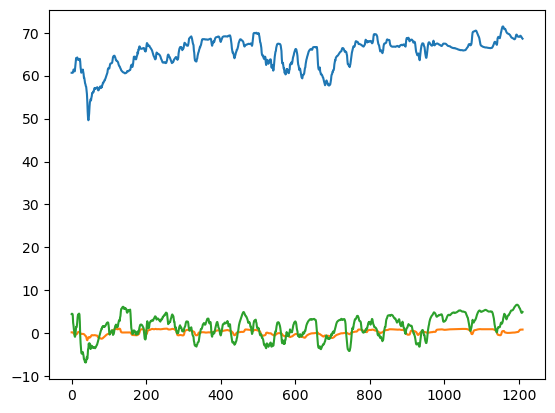

In [50]:
import matplotlib.pyplot as plt

y_pred = y_pred.cpu().numpy()
y_pred = scaler.inverse_transform(y_pred)
plt.plot(range(0,y_pred.shape[0]),y_pred[:,0])
plt.plot(range(0,y_pred.shape[0]),y_pred[:,1])
plt.plot(range(0,y_pred.shape[0]),y_pred[:,2])

In [51]:
predicted_stock = y_pred[:,0] + y_pred[:,1] + y_pred[:,2]

In [52]:
predicted_stock.shape

(1211,)

In [53]:
close = df["close"]
close = close.iloc[train_size:]
close

4918     68.627495
4919     68.968262
4920     69.109024
4921     69.293488
4922     69.055634
           ...    
6143    244.270004
6144    248.309998
6145    254.809998
6146    261.019989
6147    259.339996
Name: close, Length: 1230, dtype: float64

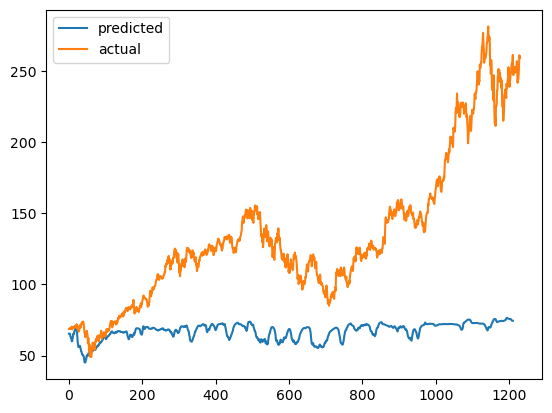

In [54]:
plt.plot(range(0,y_pred.shape[0]),predicted_stock, label = "predicted")
plt.plot(range(0,close.shape[0]), close, label = "actual")
plt.legend()
plt.show()

In [55]:
len(predicted_stock)

1211

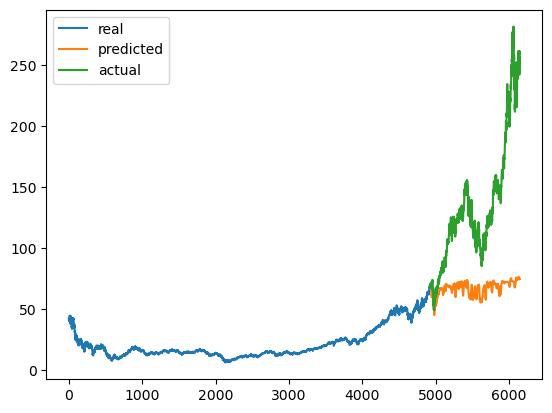

In [58]:
plt.plot(range(0,len(df["close"])-1211),df["close"].to_numpy()[:len(df["close"])-1211], label = "real")
plt.plot(range(len(df["close"])-1211, len(df["close"])), predicted_stock, label="predicted")
plt.plot(range(len(df["close"])-1230, len(df["close"])), close, label="actual")
plt.legend()
plt.show()